In [1]:
from Regression import Regression
from Franke import FrankeCentered, FrankeCenteredNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange
import skimage.measure

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
mpl.rcParams["font.size"] = 18
mpl.rcParams["lines.linewidth"] = 3

np.random.seed(1942)

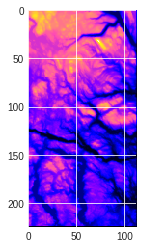

In [2]:
terrain0 = imread("../input_data/SRTM_data_Norway_1.tif")/1000
terrain1 = skimage.measure.block_reduce(terrain0, (16,16), np.mean)
plt.imshow(terrain1);
reg = Regression()

# OLS

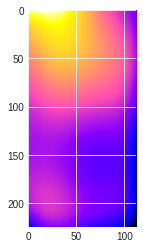

In [3]:
reg.load_matrix_data(terrain1)
beta_ols = reg.solveCoefficients(poly_order=5, solver="OLS")
data_pred_ols = reg.apply_model(beta_ols, reg.x_mesh, reg.y_mesh)

plt.imshow(data_pred_ols);

In [4]:
mse_ols_real = MSE(terrain1, data_pred_ols)
r2_ols_real = r2_score(terrain1, data_pred_ols)
print("MSE and R2 for OLS without k-folding=", mse_ols_real, r2_ols_real)

MSE and R2 for OLS without k-folding= 0.042019695328327174 0.45678001839728816


# K-FOLD

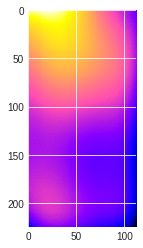

In [5]:
data_pred_Kfold = reg.solveKFold(K=10, poly_order=5, solver="OLS")
plt.imshow(data_pred_Kfold)

In [6]:
mse_ols_kfold_real = MSE(terrain1,data_pred_Kfold)
r2_ols_kfold_real = r2_score(terrain1,data_pred_Kfold)

print("MSE and R2 score for real data with OLS method and K-folding=", mse_ols_kfold_real, r2_ols_kfold_real)

MSE and R2 score for real data with OLS method and K-folding= 0.04208355246056257 0.4557984662883304


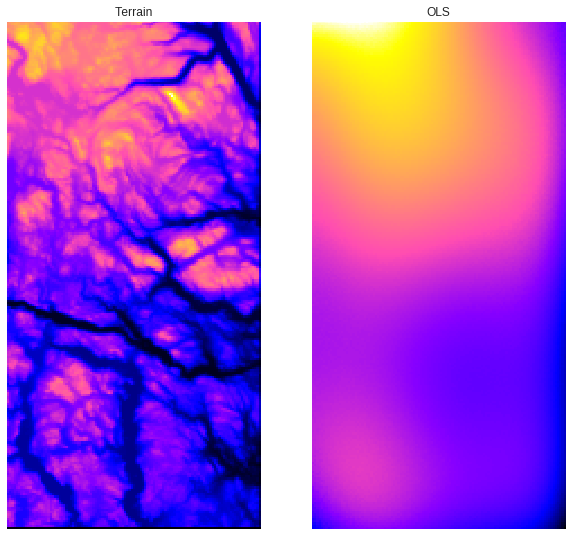

In [7]:
fig, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(terrain1)
axs[0].set_title("Terrain")
axs[0].axis("off")
axs[1].imshow(data_pred_Kfold)
axs[1].set_title("OLS")
axs[1].axis("off")
fig.tight_layout;
plt.savefig("../figs/terrain_vs_ols.pdf", bbox_inches="tight")

# RIDGE

In [8]:
mse_list_ridge = []
mse_list_noiseless_ridge = []
r2_list_ridge = []
r2_list_noiseless_ridge = []
lamda_list_ridge = np.logspace(10, -8, 16)
for i in trange(len(lamda_list_ridge)):
    lamda = lamda_list_ridge[i]
    data_pred = reg.solveKFold(K=10, poly_order=5, solver="Ridge", lamda=lamda)
    mse_list_ridge.append(MSE(terrain1, data_pred))
    r2_list_ridge.append(r2_score(terrain1, data_pred))

100%|██████████| 16/16 [00:04<00:00,  3.62it/s]


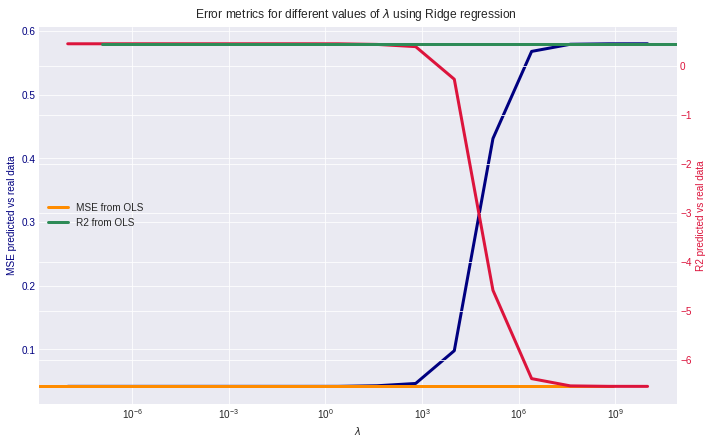

In [9]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax11 = ax1.twinx(); 
ax1.semilogx(lamda_list_ridge, mse_list_ridge, c="navy");
ax11.semilogx(lamda_list_ridge, r2_list_ridge, c="crimson");

line1 = ax1.axhline(y=mse_ols_kfold_real, xmin=0.0, xmax=0.9, color='darkorange',label="MSE from OLS")
line2 = ax11.axhline(y=r2_ols_kfold_real, xmin=0.1, xmax=1.0, color='seagreen', label="R2 from OLS")

ax1.legend((line1,line2), ("MSE from OLS", "R2 from OLS"), loc = 6)

ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("MSE predicted vs real data", color="navy");
ax11.set_ylabel("R2 predicted vs real data", color="crimson")
ax1.tick_params(axis='y', labelcolor="navy")
ax11.tick_params(axis='y', labelcolor="crimson")
fig.suptitle("Error metrics for different values of $\lambda$ using Ridge regression", y=1.02)
fig.tight_layout()
plt.savefig("../figs/errormetrics_lambda_ridge_terrain.pdf", bbox_inches="tight")

# LASSO

In [10]:
mse_list_lasso = []
r2_list_lasso = []
lamda_list_lasso = np.logspace(-3, -8, 16)
for i in trange(len(lamda_list_lasso)):
    lamda = lamda_list_ridge[i]
    data_pred = reg.solveKFold(K=10, poly_order=5, solver="Lasso", lamda=lamda)
    mse_list_lasso.append(MSE(terrain1, data_pred))
    r2_list_lasso.append(r2_score(terrain1, data_pred))

100%|██████████| 16/16 [00:57<00:00,  3.59s/it]


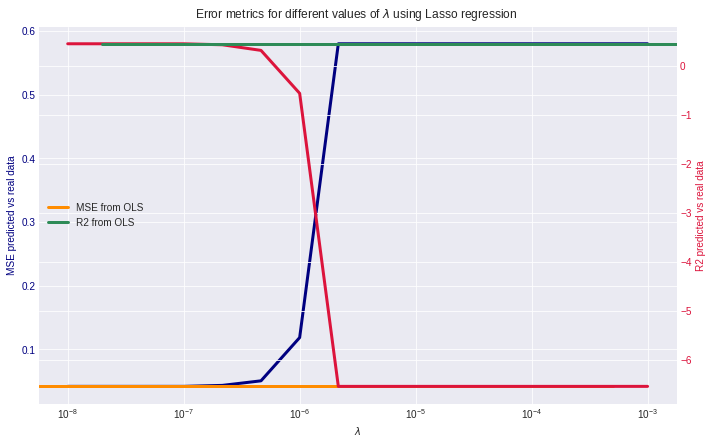

In [11]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax11 = ax1.twinx(); 
ax1.semilogx(lamda_list_lasso, mse_list_lasso, c="navy");
ax11.semilogx(lamda_list_lasso, r2_list_lasso, c="crimson");

line1 = ax1.axhline(y=mse_ols_kfold_real, xmin=0.0, xmax=0.9, color='darkorange',label="MSE from OLS")
line2 = ax11.axhline(y=r2_ols_kfold_real, xmin=0.1, xmax=1.0, color='seagreen', label="R2 from OLS")

ax1.legend((line1,line2), ("MSE from OLS", "R2 from OLS"), loc = 6)

ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("MSE predicted vs real data", color="navy");
ax11.set_ylabel("R2 predicted vs real data", color="crimson")
ax1.tick_params(axis='y', labelcolor="navy")
ax11.tick_params(axis='y', labelcolor="crimson")
fig.suptitle("Error metrics for different values of $\lambda$ using Lasso regression", y=1.02)
fig.tight_layout()
plt.savefig("../figs/errormetrics_lambda_lasso_terrain.pdf", bbox_inches="tight")

In [12]:
data_pred_ridge_optimal = reg.solveKFold(K=10, solver="Ridge", lamda=1e-3)
data_pred_lasso_optimal = reg.solveKFold(K=10, solver="Lasso", lamda=1e-7)

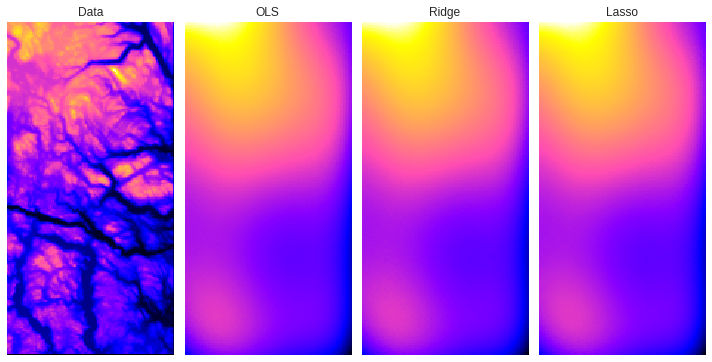

In [13]:
fig, axs = plt.subplots(1,4, figsize=(10,10))

axs[0].imshow(terrain1)
axs[0].set_title("Data")
axs[0].axis("off")
axs[1].imshow(data_pred_Kfold)
axs[1].set_title("OLS")
axs[1].axis("off")
axs[2].imshow(data_pred_ridge_optimal)
axs[2].set_title("Ridge")
axs[2].axis("off")
axs[3].imshow(data_pred_lasso_optimal)
axs[3].set_title("Lasso")
axs[3].axis("off")
fig.tight_layout()
plt.savefig("../figs/All_predictions_terrain.pdf", bbox_inches="tight")